# Finding Cu crystal ground state via the Augmented Plane method

This project is adapted from Thijssen.

## Theory

APW is a method for solving the single particle Schrodinger equation in a crystal. It uses the variational principle in the plane wave basis (this is viable due to Bloch's theorem). A basis element for an eigenstate labelled $\vec{k}$ is:

$$\psi_{\vec{k} + \vec{K}} = e^{i(\vec{k} + \vec{K})\cdot\vec{r}}\tag{1}$$

Due to the size of the potential near the nuclei, the basis set required is too large. APW solves this problem with the Muffin approximation. The equation near the nuclei ($r<R$) is solved exactly and related to the plane waves via boundary conditions at $R$. This allows for the variational method to be applied efficiently to the basis. For a full description of the theory see Thijssen. 

## Implementation

The variational equations are not linear, making the problem much harder to solve. In this implementation a brute force approach has been followed, the energy found for a given $\vec{k}$ is where the determinant changes sign.

This notebook attempts to apply this method to Cu. However, I can no longer access the data used in Thijssen for the potential. Because of this I have modelled the valence electrons potential (ignoring interaction between valence electrons) as:

$$V(r) = -Z_{eff}\frac{e^{-\frac{r}{r_0}}}{r}\tag{2}$$

where $Z_{eff}$ is the effective charge of the nuclei of the valence electron and $r_0$ has been found via the Thomas–Fermi approximation (this term represents the shielding of the nuclei by other electrons). 

These approximations are not particularly accurate; however, the implementation of the algorithm is correct.



In [497]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt

In [498]:
r_0 = 0.01
h = 0.05

#constants
a = 6.822 
R = 2.5
vol = 3*(a**3)/4

l_max = 2*(2+1) +3
nLim = 2 

#define recipricol lattice vectors 
b1 = 2*np.pi*np.array([-1,1,1])/a
b2 = 2*np.pi*np.array([1,-1,1])/a
b3 = 2*np.pi*np.array([1,1,-1])/a
Ks =[l*b1 + m*b2 + n*b3 for l in range(-nLim,nLim+1) for m in range(-nLim,nLim+1) for n in range(-nLim,nLim+1)]



In [499]:
#generate A
A = np.empty([len(Ks),len(Ks)])
for i,K_i in enumerate(Ks):
    for j,K_j in enumerate(Ks):
        kDiff = np.linalg.norm(K_i-K_j)
        if kDiff == 0:
            A[i,j] = 1
        else:
            A[i,j] = -4*np.pi*(R**2)*sp.spherical_jn(1,kDiff*R)/(vol*kDiff)





In [500]:
#code for solution to the muffin part

def iterateRK4(t_n,y_n,h,f):
    """
    Iterates by RK4 method.
    """
    k_1 = f(t_n, y_n)
    k_2 = f(t_n + h/2, y_n + h*k_1/2)
    k_3 = f(t_n + h/2, y_n + h*k_2/2)
    k_4 = f(t_n + h, y_n + h*k_3)

    return y_n + h*(k_1 + 2*k_2 + 2*k_3 + k_4)/6

def intialCond(l):
    """
    Finds intial conditions near r=0.
    """
    return np.array([r_0**(l+1),(l+1)*r_0**l])

def V(r):
    """
    Potential of the muffin system.
    """
    return -21*np.exp(-r/0.1)/r 

def getfRadial(l,E):
    """
    Generates f function for RK4 method. 
    """
    def f(r,y):
        u = y[0]
        p = y[1] #p = du/dr
        f_u = p
        f_p = (l*(l+1)/(r**2) - 2*E + 2*V(r))*u
        return np.array([f_u,f_p])
    return f
        


def getRatio(l,E):
    """
    Finds ration required for the matrix calculation.
    """
    rs = [r_0]
    ys = [intialCond(l)]
    for i in range(int((R - r_0)/h)):
        rs.append(rs[-1]+h)
        ys.append(iterateRK4(rs[-1],ys[-1],h,getfRadial(l,E)))

    return ys[-1][1]/ys[-1][0] - 1/R
    

In [501]:
def findDet(k,E):
    """
    Finds variational problem determinant
    """

    #set up k dependent matricies 
    B = np.empty([len(Ks),len(Ks)])
    C = np.empty([len(Ks),len(Ks),len(Ks)])
    qs = [k + K for K in Ks]

    #find B and C
    for i in range(len(Ks)):
        for j in range(len(Ks)):
            qDot = np.dot(qs[i],qs[j])
            B[i,j] = A[i,j]*qDot/2
            qi = np.linalg.norm(qs[i])
            qj = np.linalg.norm(qs[j])
            for l in range(l_max): 
                if qi == 0 or qj == 0:
                    C[i,j,l] = 0
                else: 
                    C[i,j,l] = (2*l + 1)*2*np.pi*(R**2)*sp.eval_legendre(l,qDot/(qi*qj))*sp.spherical_jn(l,qi*R)*sp.spherical_jn(l,qj*R)/vol
    
    H = -E*A + B
    for l in range(l_max):
        H += C[:,:,l]*getRatio(l,E)

    #this function is more approriate for large matrices, returns in (sign,absolute val
    detData = np.linalg.slogdet(H - E*np.identity(len(Ks)))
    det = detData[0]*detData[1]
    return det


In [502]:
def findZero(lst,j):
    """
    Given a list, finds the list elements that change sign.
    """
    t = 0
    for i in range(1,len(lst)):
        if (lst[i-1]>0 and lst[i]<0) or (lst[i-1]<0 and lst[i]>0):
            if t == j:
                return i
            else:
                t+=1
    return len(lst)-1

In [503]:
#defines a energy mess and finds the energy values where the determinant vanishes
ks = [2*np.pi*np.array([i/10,0,0])/a for i in range(1,11)]
EMesh  = np.arange(-0.02,0.7,step=0.01) 
E0s = np.empty(len(ks))
E1s = np.empty(len(ks))

for i,k in enumerate(ks):
    detList = [findDet(k,E) for E in EMesh]
    E0s[i] = EMesh[int(findZero(detList,0))] 
    E1s[i] = EMesh[int(findZero(detList,1))] 

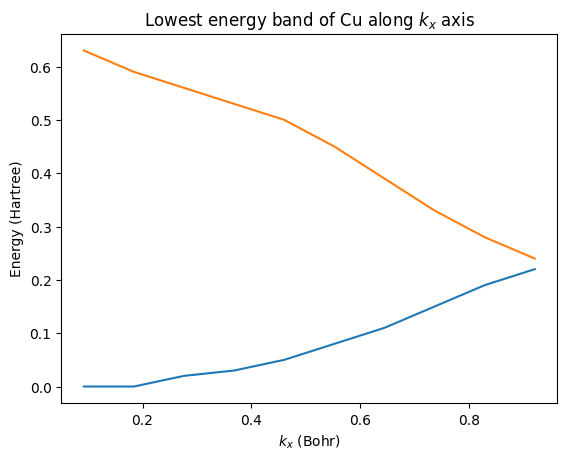

In [504]:

kx = list(map(lambda k: k[0],ks))
plt.plot(kx,E0s)
plt.plot(kx,E1s)
plt.title(R"Lowest energy band of Cu along $k_x$ axis")
plt.xlabel(r"$k_x$ (Bohr)")
plt.ylabel("Energy (Hartree)")
plt.show()